In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
    
# Enable inline plotting
%matplotlib inline

from IPython.display import display, Latex, clear_output

In [3]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S # Pysynphot
pynrc.setup_logging('WARN', verbose=False)
    
import astropy.io.fits as fits

In [4]:
# Initialize a NIRCam Grism observation in Stripe mode 
nrc = pynrc.NIRCam('F444W', pupil='GRISM0', module='A', 
                   wind_mode='STRIPE', xpix=2048, ypix=64, fov_pix=64)

In [5]:
# Update ramp settings
nrc.update_detectors(read_mode='RAPID', nint=1, ngroup=70, verbose=True)

New Ramp Settings:
  read_mode :    RAPID
  nf        :        1
  nd2       :        0
  ngroup    :       70
  nint      :        1
New Detector Settings
  wind_mode :   STRIPE
  xpix      :     2048
  ypix      :       64
  x0        :        0
  y0        :        0
New Ramp Times
  t_group   :    0.341
  t_frame   :    0.341
  t_int     :   23.843
  t_int_tot :   24.189
  t_exp     :   23.843
  t_acq     :   24.194


In [6]:
# Setup Pysynphot spectrum of the source
# K7V star normalized to K=10.2 mag
bpk = S.ObsBandpass('johnson,k')
sp = pynrc.stellar_spectrum('G2V', 8, 'vegamag', bpk)

In [7]:
# Plot the ideal grism spectrum and slope image
# Create slope image
w, im_slope = nrc.gen_psf(sp)

1444.09009555


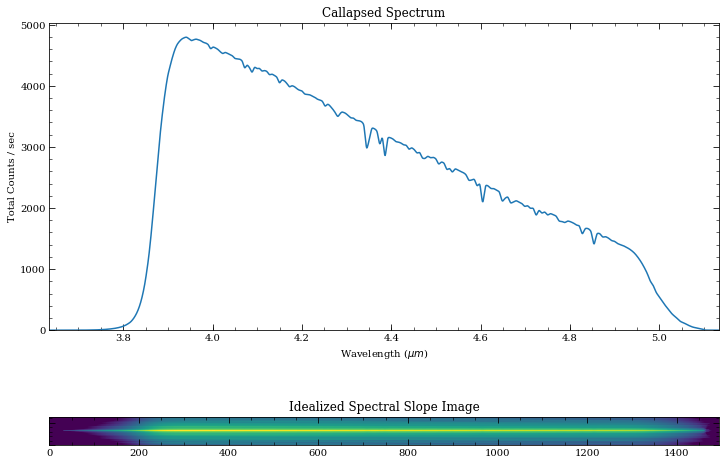

In [8]:
# Plot the collapsed spectral image w.r.t. wavelength
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(7,1)
ax1 = fig.add_subplot(gs[:-2, :])
ax2 = fig.add_subplot(gs[-1, :])

# Collapsed spectrum
ax1.plot(w, im_slope.sum(axis=0))
ax1.set_ylabel('Total Counts / sec')
ax1.set_xlabel('Wavelength ($\mu m$)')
ax1.set_title('Callapsed Spectrum')
ax1.set_ylim([0,ax1.get_ylim()[1]])
ax1.set_xlim([w.min(),w.max()])
ax1.minorticks_on()

# Show the 2D spectral image as well
vmin = 1e-2
vmax = im_slope.max()
print(vmax)
norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
ax2.imshow(im_slope, norm=norm)
ax2.set_title('Idealized Spectral Slope Image')
ax2.set_yticklabels('');

In [9]:
# The current image size is only as large as the dispersed spectrum
# Expand image to the larger detector size
xpix = nrc.det_info['xpix']
ypix = nrc.det_info['ypix']
im_slope = nrc_utils.pad_or_cut_to_size(im_slope, (ypix,xpix))
im_slope[im_slope==0] = im_slope[im_slope>0].min()

## Quick and dirty slope image of simulated data

In [23]:
# Specify name of output file.
# Time stamps will be automatically inserted for unique file names.
#file_out = '/Volumes/NIRData/grism_sim/grism_sim.fits'
# Create a simulated integration based on observation settings
res_sp = nrc.gen_exposures(sp, file_out=None)

# Result is a list of HDULists, each with a number of extensions:
# 1. 'PRIMARY'
# 2. 'SCI'
# 3. 'ZEROFRAME'

In [24]:
header = res_sp[0]['PRIMARY'].header
data = res_sp[0]['SCI'].data
ng,ny,nx = data.shape

# Reference pixel correction
ref = pynrc.ref_pixels.NRC_refs(data, header, DMS=True, do_all=True)

# Integration values of each group in ramp
tvals = (np.arange(ng)+1) * nrc.multiaccum_times['t_group']

# Linear fit each pixel and return coefficiencts
coeffs = nrc_utils.jl_poly_fit(tvals, ref.data, deg=1)
im_slope_sim = coeffs[1,:,:] * nrc.Detectors[0].gain

Converting data from uint16 to float64


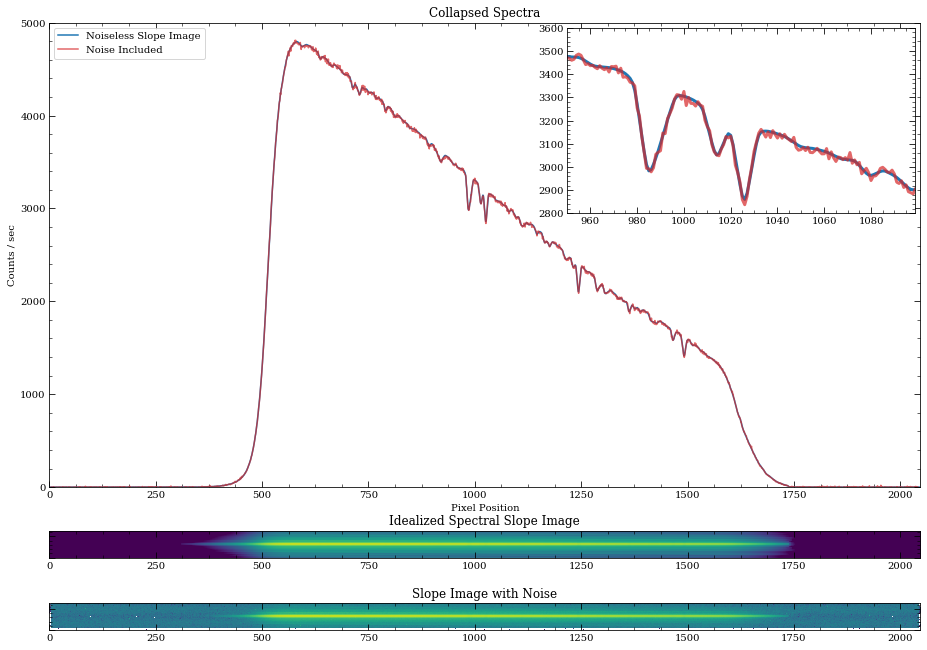

In [36]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
colors = ['C0', 'C1', 'C2', 'C3']

fig = plt.figure(figsize=(13,9))
gs = gridspec.GridSpec(9,1)
ax1 = fig.add_subplot(gs[:-2, :])
ax2 = fig.add_subplot(gs[-2, :])
ax3 = fig.add_subplot(gs[-1, :])

# Collapsed spectra
# Remove background
c1 = im_slope.sum(axis=0)
c1 -= np.median(c1[1900:])
c2 = im_slope_sim.sum(axis=0)
c2 -= np.median(c2[1900:])

xvals = np.arange(len(c1))
ax1.plot(xvals, c1, label='Noiseless Slope Image')
ax1.plot(xvals, c2, color='C3', alpha=0.7, label='Noise Included')
ax1.set_ylabel('Counts / sec')
ax1.set_xlabel('Pixel Position')
ax1.set_title('Collapsed Spectra')
ax1.minorticks_on()
ax1.legend(loc=2)
ax1.set_xlim([0,2047])
ax1.set_ylim([0,5000])

inset_axes = inset_axes(ax1, width="40%",height="40%",loc=1)
inset_axes.plot(xvals, c1, lw=3)
inset_axes.plot(xvals, c2, color='C3', lw=3, alpha=0.7)
inset_axes.set_xlim([950,1099])
inset_axes.set_ylim([2800,3600])
inset_axes.minorticks_on()

# Show the 2D spectral image as well
vmin = 1e-2
vmax = im_slope.max()
#print(vmax)
norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
ax2.imshow(im_slope, norm=norm)
ax2.set_yticklabels('')
ax2.set_title('Idealized Spectral Slope Image')

ax3.imshow(im_slope_sim, norm=norm)
ax3.set_yticklabels('')
ax3.set_title('Slope Image with Noise')

fig.tight_layout()